In [3]:
import sys, os
sys.path.append(os.pardir)
from common.layers import *
from common.functions import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

    # 계층 생성
    self.layers = OrderedDict()
    self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
    self.layers['Relu1'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
    
    self.lastLayer = SoftmaxWithLoss()
  
  # def predict(self, x):
  #   W1, W2 = self.params['W1'], self.params['W2']
  #   b1, b2 = self.params['b1'], self.params['b2']

  #   a1 = np.dot(x, W1) + b1
  #   z1 = sigmoid(a1)
  #   a2 = np.dot(z1, W2) + b2
  #   y = softmax(a2)

  #   return y

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)
    
    return x
  
  def loss(self, x, t):
    y = self.predict(x)

    return self.lastLayer.forward(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    if t.ndim != 1 : t = np.argmax(t, axis=1)

    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy

  def numerical_gradient(self, x, t):
    loss_W = lambda W: self.loss(x, t)

    grads = {}
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

    return grads
  
  def gradient(self, x, t):
    self.loss(x, t)

    dout = 1
    dout = self.lastLayer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)
    
    grads = {}
    grads['W1'] = self.layers['Affine1'].dW
    grads['b1'] = self.layers['Affine1'].db
    grads['W2'] = self.layers['Affine2'].dW
    grads['b2'] = self.layers['Affine2'].db

    return grads

In [4]:
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
  diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
  print(key + ':' + str(diff))

W1:4.223936237225522e-10
b1:2.6328337169245155e-09
W2:6.789904260344601e-09
b2:1.3972403329620687e-07


In [5]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)

for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  grad = network.gradient(x_batch, t_batch)

  for key in ('W1', "b1", "W2", "b2"):
    network.params[key] -= learning_rate * grad[key]

  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  if i % iter_per_epoch == 0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(test_acc)
    test_acc_list.append(test_acc)
    print(f'{i / iter_per_epoch} {train_acc}, {test_acc}')


0.0 0.19276666666666667, 0.1925
1.0 0.9033333333333333, 0.9064
2.0 0.9177833333333333, 0.9186
3.0 0.9338666666666666, 0.9337
4.0 0.94385, 0.9405
5.0 0.9513666666666667, 0.9482
6.0 0.95285, 0.9495
7.0 0.9590333333333333, 0.9535
8.0 0.9633, 0.9577
9.0 0.9653333333333334, 0.9599
10.0 0.9682166666666666, 0.9627
11.0 0.9698666666666667, 0.9634
12.0 0.9720833333333333, 0.9654
13.0 0.9736666666666667, 0.9665
14.0 0.9754666666666667, 0.9674
15.0 0.9766666666666667, 0.9697
16.0 0.9778333333333333, 0.9701


[np.float64(2.299123044338871), np.float64(2.2987625558807316), np.float64(2.2990961096327793), np.float64(2.294718864388042), np.float64(2.2970811611036424), np.float64(2.2983297118915185), np.float64(2.2951334826238154), np.float64(2.294601643033807), np.float64(2.2957398360074333), np.float64(2.296062766845605), np.float64(2.2901020067323117), np.float64(2.292730551618421), np.float64(2.2901266337980752), np.float64(2.2922079074740243), np.float64(2.287300463949324), np.float64(2.285682741457452), np.float64(2.2891500646588985), np.float64(2.2865603024438186), np.float64(2.282368096304858), np.float64(2.2852536627994082), np.float64(2.2870566810342448), np.float64(2.2791267969168048), np.float64(2.2741625958189258), np.float64(2.269265219155028), np.float64(2.273726949325158), np.float64(2.2729773303593204), np.float64(2.2608295611104987), np.float64(2.2626351247267236), np.float64(2.259024956849397), np.float64(2.265188883684901), np.float64(2.257961493968663), np.float64(2.2538851

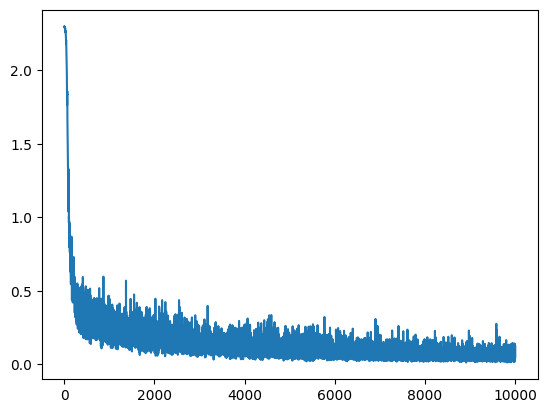

In [7]:
import matplotlib.pylab as plt

plt.plot(range(len(train_loss_list)), train_loss_list)
print(train_loss_list)
